### Import python files from another directory
In order to reuse code written in .py files you need to import them. <br/>
If they are from a distant folder, rather than copy-paste it into the current folder, you can write:

In [15]:
import sys
sys.path.append("../../ex02/template") # This goes up twice in the directories tree (hence in labs)
                                       # then goes down to ex02/template where your files from lab 2 are.

you can now import your desired files, for example, we can import grid_search.py with:

In [16]:
import grid_search        # You then need to call your functions using grid_search.function_name()
import grid_search as gs  # You then need to call your functions using gs.function_name()
from grid_search import * # You can call any functions of the file with function_name()

# Let's try to call generate_w from grid_search.py:
w0, w1 = generate_w(5)
print(w0, w1)

[-100.  -25.   50.  125.  200.] [-150.  -75.    0.   75.  150.]


As you can see we are now able to call functions from the grid_search.py file.

In [17]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 1 Least squares and linear basis functions models
## 1.1 Least squares

In [18]:
def least_squares(y, tx):
    """calculate the least squares solution."""
    n = len(y)
    w_star = np.linalg.solve(tx.T @ tx, tx.T @ y)
    e = y - (tx @ w_star)
    loss_star = (e.T @ e) / (2 * n)
    return loss_star, w_star

### Load the data
Here we will reuse the dataset `height_weight_genders.csv` from previous exercise section to check the correctness of your implementation. Please compare it with your previous result.

In [19]:
from grid_search import *
from helpers import *


def test_your_least_squares(num_intervals=100):
    height, weight, gender = load_data_from_ex02(sub_sample=False, add_outlier=False)
    x, mean_x, std_x = standardize(height)
    y, tx = build_model_data(x, weight)

    # Least squares
    loss_star_ls, w_star_ls = least_squares(y, tx)
    w0_star_ls, w1_star_ls = w_star_ls

    # Show least squares results
    print(f'Least Squares: loss*={loss_star_ls}, w0*={w0_star_ls}, w1*={w1_star_ls}')

    # Grid search
    # Generate the grid of parameters to be swept
    grid_w0, grid_w1 = generate_w(num_intervals=num_intervals)

    # Start the grid search
    grid_losses = grid_search(y, tx, grid_w0, grid_w1)

    # Select the best combinaison
    loss_star_gs, w0_star_gs, w1_star_gs = get_best_parameters(
        grid_w0, grid_w1, grid_losses)

    # Show grid search results
    print(f'Grid Search: loss*={loss_star_gs}, w0*={w0_star_gs}, w1*={w1_star_gs}')

Test it here

In [20]:
test_your_least_squares()

Least Squares: loss*=15.385887868829395, w0*=73.29392200210518, w1*=13.479712434989061
Grid Search: loss*=15.558703368609525, w0*=72.72727272727272, w1*=13.636363636363626


## 1.2 Least squares with a linear basis function model
Start from this section, we will use the dataset `dataEx3.csv`.

### Implement polynomial basis functions

In [21]:
# load dataset
x, y = load_data()
print("shape of x {}".format(x.shape))
print("shape of y {}".format(y.shape))

shape of x (50,)
shape of y (50,)


In [22]:
def build_poly(x, degree):
    """polynomial basis functions for input data x, for j=0 up to j=degree."""
    phi_n = lambda x_n: [x_n**d for d in range(degree + 1)]
    return np.array(list(map(phi_n, x)))

Let us play with polynomial regression. Note that we will use your implemented function `compute_mse`. Please copy and paste your implementation from exercise02.

In [23]:
def compute_mse(y, tx, w):
    """Calculate the loss using mse."""
    n = len(y)
    e = y - (tx @ w)
    return (e @ e) / (2 * n)

In [24]:
from plots import *


def polynomial_regression():
    """Constructing the polynomial basis function expansion of the data,
       and then running least squares regression."""
    # define parameters
    degrees = [1, 3, 7, 12]

    # define the structure of the figure
    num_row = 2
    num_col = 2
    f, axs = plt.subplots(num_row, num_col)

    for ind, degree in enumerate(degrees):
        # form the data to do polynomial regression
        phi = build_poly(x, degree)
        # least square and calculate RMSE
        mse, weights = least_squares(y, phi)
        rmse = np.sqrt(2 * mse)
        print("Processing {i}th experiment, degree={d}, rmse={loss}".format(
              i=ind + 1, d=degree, loss=rmse))
        # plot fit
        plot_fitted_curve(
            y, x, weights, degree, axs[ind // num_col][ind % num_col])
    plt.tight_layout()
    # plt.savefig("visualize_polynomial_regression")
    plt.show()

Run polynomial regression

Processing 1th experiment, degree=1, rmse=0.4718760796342188
Processing 2th experiment, degree=3, rmse=0.258582776677375
Processing 3th experiment, degree=7, rmse=0.24965870360907347
Processing 4th experiment, degree=12, rmse=0.24337224835787005


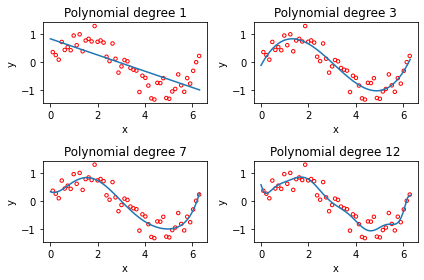

In [25]:
polynomial_regression()

# 2 Evaluating model predication performance


Let us show the train and test splits for various polynomial degrees. First of all, please fill in the function `split_data()`

In [26]:
def split_data(x, y, ratio, seed=1):
    """
    split the dataset based on the split ratio. If ratio is 0.8 
    you will have 80% of your data set dedicated to training 
    and the rest dedicated to testing
    """
    # set seed
    np.random.seed(seed)
    # split the data based on the given ratio
    n = x.shape[0]
    split_idx = int(n * ratio)
    indices = np.random.permutation(n)
    training_idx, test_idx = indices[:split_idx], indices[split_idx:]
    training_x, test_x = x[training_idx], x[test_idx]
    training_y, test_y = y[training_idx], y[test_idx]
    return training_x, test_x, training_y, test_y

Then, test your `split_data` function below.

In [27]:
def train_test_split_demo(x, y, degree, ratio, seed):
    """polynomial regression with different split ratios and different degrees."""
    # split the data, and return train and test data
    x_tr, x_te, y_tr, y_te = split_data(x, y, ratio, seed)
    # form train and test data with polynomial basis function
    phi_tr = build_poly(x_tr, degree)
    phi_te = build_poly(x_te, degree)
    # calculate weight through least square
    mse_tr, weights_tr = least_squares(y_tr, phi_tr)
    mse_te, weights_te = least_squares(y_te, phi_te)
    # calculate RMSE for train and test data,
    # and store them in rmse_tr and rmse_te respectively
    rmse_tr = np.sqrt(2 * mse_tr)
    rmse_te = np.sqrt(2 * mse_te)
    print("proportion={p}, degree={d}, Training RMSE={tr:.3f}, Testing RMSE={te:.3f}".format(
          p=ratio, d=degree, tr=rmse_tr, te=rmse_te))


In [28]:
seed = 6
degrees = [1, 3, 7, 12]
split_ratios = [0.9, 0.5, 0.1]

for split_ratio in split_ratios:
    for degree in degrees:
        train_test_split_demo(x, y, degree, split_ratio, seed)

proportion=0.9, degree=1, Training RMSE=0.494, Testing RMSE=0.157
proportion=0.9, degree=3, Training RMSE=0.264, Testing RMSE=0.086
proportion=0.9, degree=7, Training RMSE=0.254, Testing RMSE=0.000
proportion=0.9, degree=12, Training RMSE=0.242, Testing RMSE=0.000
proportion=0.5, degree=1, Training RMSE=0.455, Testing RMSE=0.450
proportion=0.5, degree=3, Training RMSE=0.239, Testing RMSE=0.255
proportion=0.5, degree=7, Training RMSE=0.232, Testing RMSE=0.247
proportion=0.5, degree=12, Training RMSE=0.205, Testing RMSE=0.228
proportion=0.1, degree=1, Training RMSE=0.428, Testing RMSE=0.468
proportion=0.1, degree=3, Training RMSE=0.085, Testing RMSE=0.251
proportion=0.1, degree=7, Training RMSE=0.000, Testing RMSE=0.247
proportion=0.1, degree=12, Training RMSE=0.000, Testing RMSE=0.234


# 3 Ridge Regression
Please fill in the function below.

In [29]:
def ridge_regression(y, tx, lambda_):
    """implement ridge regression."""
    n, m = tx.shape
    w_star = np.linalg.solve((tx.T @ tx) + lambda_ * np.eye(m), tx.T @ y)
    e = y - (tx @ w_star)
    loss_star = (e.T @ e) / (2 * m)
    return loss_star, w_star

In [30]:
from helpers import *


def test_ridge_regression(lambda_=0):
    height, weight, gender = load_data_from_ex02(sub_sample=False, add_outlier=False)
    x, mean_x, std_x = standardize(height)
    y, tx = build_model_data(x, weight)

    # Ridge regression
    loss_star_ls, w_star_ls = ridge_regression(y, tx, lambda_)
    w0_star_ls, w1_star_ls = w_star_ls

    # Show ridge regression results
    print(f'Ridge Regression: loss*={loss_star_ls}, w0*={w0_star_ls}, w1*={w1_star_ls}')

    # Least squares
    loss_star_ls, w_star_ls = least_squares(y, tx)
    w0_star_ls, w1_star_ls = w_star_ls

    # Show least squares results
    print(f'Least Squares: loss*={loss_star_ls}, w0*={w0_star_ls}, w1*={w1_star_ls}')

In [31]:
test_ridge_regression(0)

Ridge Regression: loss*=76929.43934414697, w0*=73.29392200210518, w1*=13.479712434989061
Least Squares: loss*=15.385887868829395, w0*=73.29392200210518, w1*=13.479712434989061


In [32]:
def ridge_regression_demo(x, y, degree, ratio, seed):
    """ridge regression demo."""
    # define parameter
    lambdas = np.logspace(-5, 0, 15)
    # split the data, and return train and test data
    x_tr, x_te, y_tr, y_te = split_data(x, y, ratio, seed)
    # form train and test data with polynomial basis function
    phi_tr = build_poly(x_tr, degree)
    phi_te = build_poly(x_te, degree)

    rmse_tr = []
    rmse_te = []
    for ind, lambda_ in enumerate(lambdas):
        # ridge regression with a given lambda
        mse_tr, weights_tr = ridge_regression(y_tr, phi_tr, lambda_)
        mse_te, weights_te = ridge_regression(y_te, phi_te, lambda_)
        # calculate RMSE for train and test data,
        # and store them in rmse_tr and rmse_te respectively
        rmse_tr.append(np.sqrt(2 * mse_tr))
        rmse_te.append(np.sqrt(2 * mse_te))
        print("proportion={p}, degree={d}, lambda={l:.3f}, Training RMSE={tr:.3f}, Testing RMSE={te:.3f}".format(
               p=ratio, d=degree, l=lambda_, tr=rmse_tr[ind], te=rmse_te[ind]))

    # Plot the obtained results
    plot_train_test(rmse_tr, rmse_te, lambdas, degree)

proportion=0.5, degree=7, lambda=0.000, Training RMSE=0.402, Testing RMSE=0.397
proportion=0.5, degree=7, lambda=0.000, Training RMSE=0.402, Testing RMSE=0.397
proportion=0.5, degree=7, lambda=0.000, Training RMSE=0.402, Testing RMSE=0.397
proportion=0.5, degree=7, lambda=0.000, Training RMSE=0.402, Testing RMSE=0.397
proportion=0.5, degree=7, lambda=0.000, Training RMSE=0.402, Testing RMSE=0.398
proportion=0.5, degree=7, lambda=0.001, Training RMSE=0.402, Testing RMSE=0.398
proportion=0.5, degree=7, lambda=0.001, Training RMSE=0.402, Testing RMSE=0.399
proportion=0.5, degree=7, lambda=0.003, Training RMSE=0.402, Testing RMSE=0.400
proportion=0.5, degree=7, lambda=0.007, Training RMSE=0.402, Testing RMSE=0.401
proportion=0.5, degree=7, lambda=0.016, Training RMSE=0.403, Testing RMSE=0.402
proportion=0.5, degree=7, lambda=0.037, Training RMSE=0.404, Testing RMSE=0.403
proportion=0.5, degree=7, lambda=0.085, Training RMSE=0.406, Testing RMSE=0.403
proportion=0.5, degree=7, lambda=0.193, 

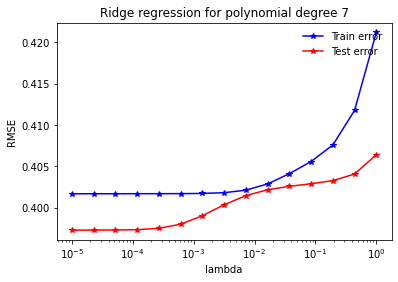

In [33]:
seed = 56
degree = 7
split_ratio = 0.5
ridge_regression_demo(x, y, degree, split_ratio, seed)